In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import scipy.optimize as opt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
import os
from data_preprocessing import FilteringCurves, ShowResponseCurves
from fitting_curves import FittingColumn, ShowResponseCurvesWithFitting, compute_r2_score
_FOLDER = "./data/"

In [3]:
os.listdir("./results/")

['merged_drug_profiles_sigmoid4_23.csv',
 'filtered_drug_profiles_13.csv',
 'filtered_drug_profiles_12.csv',
 'filtered_drug_profiles_23.csv',
 'filtered_drug_profiles.csv',
 'merged_drug_profiles_sigmoid4_123.csv',
 'filtered_drug_profiles_123.csv']

In [4]:
# NEED TO CHANGE - what file to read
df = pd.read_csv("./results/merged_drug_profiles_sigmoid4_123.csv")
df.shape

(2612, 1100)

In [5]:
conc_columns= ["fd_num_"+str(i) for i in range(10)]
response_norm = ['norm_cells_'+str(i) for i in range(10)]

In [7]:
cell_features = pd.read_csv(_FOLDER+"Cell_Line_Features_PANCAN_simple_MOBEM.tsv", sep="\t")

stat_data = df.groupby(["DRUG_ID"])[["COSMIC_ID"]].count().rename(columns={"COSMIC_ID": "count_cell_lines"})\
            .sort_values("count_cell_lines", ascending=False)
    

drug_features = pd.read_csv(_FOLDER+'/Drug_Features.csv').rename(columns = {"Drug ID": "DRUG_ID"})
statistics = pd.merge(left = stat_data, right = drug_features, how= "left", on = "DRUG_ID").sort_values("count_cell_lines", ascending =False)
statistics.head(10)

,DRUG_ID,count_cell_lines,Drug Name,Synonyms,Target,Target Pathway
0,328,115,SNX-2112,SNX 2112,HSP90,Protein stability and degradation
1,272,107,AR-42,"HDAC-42, AR 42, AR42",HDAC1,Chromatin histone acetylation
2,273,106,CUDC-101,CUDC 101,"HDAC1-10, EGFR, ERBB2",Other
3,170,102,Shikonin,Anchusin,not defined,Other
4,274,100,Belinostat,"PXD101, PXD-101",HDAC1,Chromatin histone acetylation
5,276,100,CAY10603,-,"HDAC1, HDAC6",Chromatin histone acetylation
6,200,87,Dacinostat,"NVP-LAQ824, LAQ824",HDAC1,Chromatin histone acetylation
7,219,86,AT-7519,AT7519,"CDK1, CDK2, CDK4, CDK6, CDK9",Cell cycle
8,180,72,Thapsigargin,Octanoic acid,SERCA,Other
9,346,57,THZ-2-102-1,-,CDK7,Cell cycle


### Training and testing tuned kernels

In [8]:
# select subsets for each drug and divide each of them into train and test data
# concatenate all the train and test subsets

gr = df.groupby(["DRUG_ID"])["COSMIC_ID"].count()
good_drug_ids = gr[gr>50].index
len(good_drug_ids)

11

In [9]:
%%time
train = pd.DataFrame(columns=df.columns)
test = pd.DataFrame(columns=df.columns)

for drug_id in good_drug_ids:
    df_i = df[df["DRUG_ID"]==drug_id]
    np.random.seed(123)
    indexes = np.random.permutation(df_i.index)
    train_size = int(df_i.shape[0]*0.7)
    indexes_train = indexes[:train_size]
    indexes_test= indexes[train_size:]
    
    train_set = df_i.loc[indexes_train, :]
    test_set = df_i.loc[indexes_test, :]
    
    train = pd.concat([train, train_set], axis=0)
    test = pd.concat([test, test_set], axis=0)
    
print(train.shape, test.shape)

(683, 1100) (300, 1100)
CPU times: user 496 ms, sys: 65.9 ms, total: 561 ms
Wall time: 577 ms


In [ ]:
def TrainKernelByDrug(train_data, number_coefficients, kernel='linear', param_tested = "alpha", 
                       param_tested_values = [], alpha=1, gamma=None, degree=3, coef0=1,
                      display_results=True):
    
    df_errors = pd.DataFrame()
    #check whether each coefficient needs its own parameters
    

    for drug_id in drug_ids:
        X_train = train_data.loc[indexes_train, merged_df_i.columns[26:-4]].values
    
        for i in range(number_coefficients):
            #check whether each coefficient needs its own parameters
            if type(alpha)==dict:
                alpha_value = alpha[i+1]
            else:
                alpha_value = alpha
                
            if type(gamma)==dict:
                gamma_value = gamma[i+1]
            else:
                gamma_value = gamma
            
            if type(degree)==dict:
                degree_value = degree[i+1]
            else:
                degree_value = degree
                
            if type(coef0)==dict:
                coef0_value = coef0[i+1]
            else:
                coef0_value = coef0
            
            y_train = train_data.loc[indexes_train, "param_"+str(i+1)].values
            for param in param_tested_values:
    
                #check whether each coefficient needs its own parameters
                if param_tested == "alpha":
                    kernel_model = KernelRidge(kernel=kernel, 
                                               alpha=param, 
                                               gamma=gamma_value, 
                                               degree=degree_value, 
                                               coef0=coef0_value)
                elif param_tested == "gamma":
                    kernel_model = KernelRidge(kernel=kernel, 
                                               alpha=alpha_value, 
                                               gamma=param, 
                                               degree=degree_value,
                                               coef0=coef0_value)
                elif param_tested == "degree":
                    kernel_model = KernelRidge(kernel=kernel, 
                                               alpha=alpha_value, 
                                               gamma=gamma_value,
                                               degree=param, 
                                               coef0=coef0_value)
                elif param_tested == "coef0":
                    kernel_model = KernelRidge(kernel=kernel, 
                                               alpha=alpha_value,  
                                               gamma=gamma_value,
                                               degree=degree_value,
                                               coef0=param)
                else:
                    print("ERROR: Unknown parameters")

        return kernel_model.fit(X_train, y_train)


def TestTunedKernels(drug_ids, number_coefficients, kernel, alpha=1, gamma=None, degree=3, coef0=1, 
                     metrics = "mse", display_results=True):
    """Training and testing Kernels with the best found hyperparameters"""
    
    df_errors_test = pd.DataFrame()

    for drug_id in drug_ids:
        # merged_df_i has lower shape
        merged_df_i = merged_df[merged_df["DRUG_ID"]==drug_id]
        
        np.random.seed(123)
        indexes = np.random.permutation(merged_df_i.index)
        train_size = int(merged_df_i.shape[0]*0.8)
        indexes_train = indexes[:train_size]
        indexes_test= indexes[train_size:]
        X_train = merged_df_i.loc[indexes_train, merged_df_i.columns[26:-4]].values
        X_test = merged_df_i.loc[indexes_test, merged_df_i.columns[26:-4]].values
    
        for i in range(number_coefficients):
#             param = best_param[i+1]
            y_train = merged_df_i.loc[indexes_train, "param_"+str(i+1)].values
            y_test = merged_df_i.loc[indexes_test, "param_"+str(i+1)].values
            
            #check whether each coefficient needs its own parameters
            if type(alpha)==dict:
                alpha_value = alpha[i+1]
            else:
                alpha_value = alpha
                
            if type(gamma)==dict:
                gamma_value = gamma[i+1]
            else:
                gamma_value = gamma
            
            if type(degree)==dict:
                degree_value = degree[i+1]
            else:
                degree_value = degree
                
            if type(coef0)==dict:
                coef0_value = coef0[i+1]
            else:
                coef0_value = coef0
                
            kr_lin = KernelRidge(kernel = kernel, alpha = alpha_value, gamma=gamma_value, 
                                 degree=degree_value, coef0=coef0_value)
            kr_lin.fit(X_train, y_train)
            y_pred = kr_lin.predict(X_test)
            
            # mse is more sensitive to different parameters choice
            if metrics == "mse":
                error = mean_squared_error(y_test, y_pred)
            elif metrics == "mae":
                error = mean_absolute_error(y_test, y_pred)
            else:
                print("ERROR: Unknown metrics")
            df_errors_test.loc[drug_id, kernel+"_mse_coef"+str(i+1)] = error
    
    df_results = df_errors_test.describe().loc[["mean", "min","max"], :]
    if display_results:
        print("Testing %s kernel with tuned hyperparameters\n" % kernel)
        print("Coefficients x0, L, k, b   y = 1/ (L + np.exp(-k*(x-x0)))+b") 
        display(df_results)
    return df_results

In [ ]:
TrainKernelByDrug

In [10]:
%%time

df_errors = pd.DataFrame()
df_errors["DRUG_ID"] = good_drug_ids
df_errors.set_index("DRUG_ID", inplace =True)

test_columns_to_use = ['COSMIC_ID', 'DRUG_ID']+conc_columns+response_norm+["param_"+str(i)for i in range(1,5)]
short_test = test[test_columns_to_use].copy()

for drug_id in df_errors.index:
    
    train_i = train[train["DRUG_ID"]==drug_id]
    test_i = test[test["DRUG_ID"]==drug_id]

    X_train = train_i[train_i.columns[26:-4]].values
    X_test = test_i[test_i.columns[26:-4]].values

    for i in range(4):
        y_train = train_i["param_"+str(i+1)]
        y_test = test_i["param_"+str(i+1)]
        
        # train kernels with best parameters
        # @ TO CHANGE !!!
        kr_lin = KernelRidge(kernel='linear')
        kr_lin.fit(X_train, y_train)
        y_pred = kr_lin.predict(X_test)
        
        # collect errors
        mse = mean_squared_error(y_test, y_pred)
        df_errors.loc[drug_id, "mse_param_"+str(i+1)] = mse
        mae = mean_absolute_error(y_test, y_pred)
        df_errors.loc[drug_id, "mae_param_"+str(i+1)] = mae
        
        # show on graph fitted and predicted curves
        # not all the data was merged=learnd by the model
        short_test.loc[test_i.index, "pred_param_"+str(i+1)] = kr_lin.predict(X_test)
#         print(merged_df.loc[merged_df_i.index, "pred_param_"+str(i+1)])

CPU times: user 934 ms, sys: 91.4 ms, total: 1.03 s
Wall time: 596 ms


In [12]:
# parameters: x0, L, k, b
# y = 1 / (L + np.exp(-k*(x-x0)))+b
# Wang 1.0 / (1.0 + np.exp((x-p)/s)   x - dosage [0, 1], p - position, s - shape parameter
short_test[['COSMIC_ID', 'DRUG_ID', "param_1","pred_param_1","param_2", "pred_param_2", 
            "param_3", "pred_param_3", "param_4", "pred_param_4"]].head()

,COSMIC_ID,DRUG_ID,param_1,pred_param_1,param_2,pred_param_2,param_3,pred_param_3,param_4,pred_param_4
835,907043,170,0.363850,0.393212,1.033021,0.746965,-51.693547,-47.058598,0.007548,0.023764
709,910853,170,0.282951,0.434306,0.991244,1.027353,-17.902582,-58.329858,0.001505,0.010678
588,1331048,170,0.391543,0.197077,1.165887,0.586832,-29.009874,-3.235111,0.124297,0.010400
1164,1298531,170,0.330063,0.418406,1.032297,0.829837,-21.884331,-16.785437,0.016542,0.019082
134,906817,170,0.455416,0.580067,1.027351,1.354280,-19.649939,-92.787808,0.025061,0.054867


In [14]:
fitting_cols = ["param_"+str(i) for i in range(1,5)]
pred_fitting_cols = ["pred_param_"+str(i) for i in range(1,5)]
fitting_function = "sigmoid_4_param"

In [15]:
short_test["r2_fitted"] = compute_r2_score(short_test, x_columns = conc_columns, y_columns = response_norm, 
                              fitting_parameters=fitting_cols, fitting_function = fitting_function)

short_test["r2_predicted"] = compute_r2_score(short_test, x_columns = conc_columns, y_columns = response_norm, 
                              fitting_parameters=pred_fitting_cols, fitting_function = fitting_function)

In [22]:
# only one case when predicted values was a better fit to original data than directly fitted
short_test[short_test["r2_predicted"]>short_test["r2_fitted"]][["DRUG_ID","r2_fitted", "r2_predicted"]]

,DRUG_ID,r2_fitted,r2_predicted
1606,219,5.050434e-08,0.71805


In [25]:
short_test[short_test["DRUG_ID"]==219][["DRUG_ID","r2_fitted", "r2_predicted"]].shape

(26, 3)

Figures titles: Index_DRUG_ID_COSMIC_ID (COSMIC_ID is a cell line)


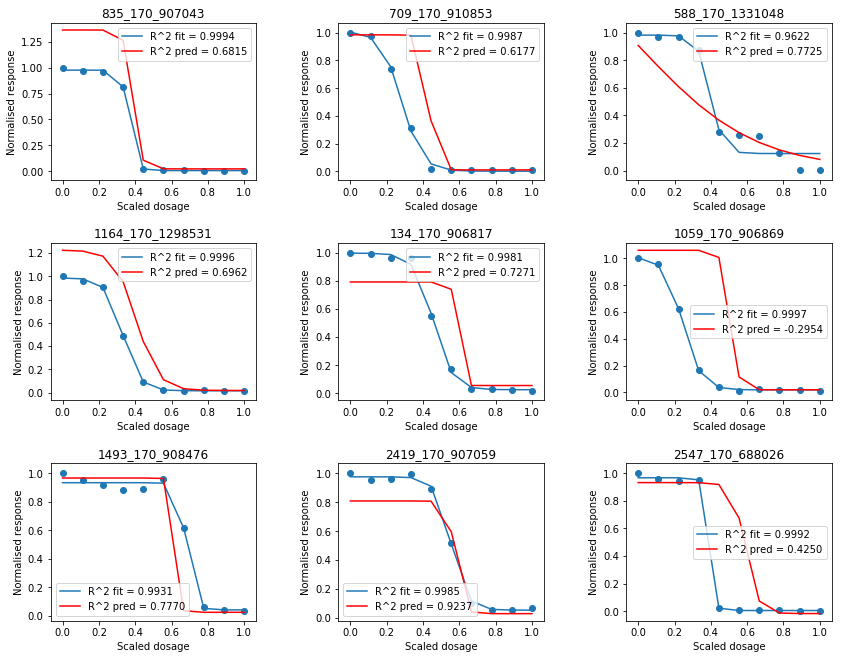

In [19]:
df = short_test
ShowResponseCurvesWithFitting(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, 
                              y_columns = response_norm, indexes=df.index[:9], 
                              fitting_function = fitting_function, fitting_parameters = fitting_cols,
                             pred_fitting_param=pred_fitting_cols)

In [26]:
# x0, L, k, b   y = 1/ (L + np.exp(-k*(x-x0)))+b

df_errors.describe()

,mse_param_1,mae_param_1,mse_param_2,mae_param_2,mse_param_3,mae_param_3,mse_param_4,mae_param_4
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,2.904070,0.678699,6.018416,0.894316,591.589625,14.209816,0.030484,0.089112
std,4.695010,0.697080,9.992729,0.896737,664.961714,8.015762,0.057176,0.033918
min,0.021081,0.113052,0.093379,0.236605,66.275078,6.748200,0.003616,0.029845
25%,0.055201,0.194046,0.249604,0.408432,115.489903,8.511401,0.009314,0.065713
50%,0.935599,0.546047,0.476037,0.534229,360.710725,11.234837,0.013485,0.090251
75%,3.005612,0.741883,8.446279,0.967509,788.979109,17.781224,0.019686,0.110931
max,14.729717,2.561256,31.784409,3.344451,1941.714281,33.002168,0.201778,0.144722


Mean Squared errors for 11 drugs


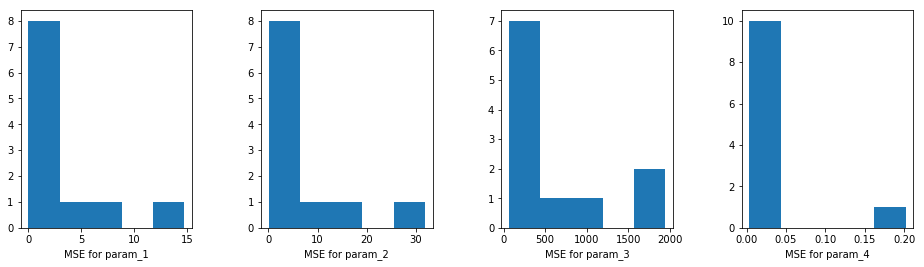

In [27]:
# parameters: x0, L, k, b
# y = 1/ (L + np.exp(-k*(x-x0)))+b

fig = plt.figure(figsize=(16, 4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
n_plots= 4
parameters_to_show = ["mse_param_"+str(i+1) for i in range(4)]
print("Mean Squared errors for %d drugs" % df_errors.shape[0])
for i in range(n_plots):
    ax = fig.add_subplot(1, n_plots, i+1)
    ax.hist(df_errors[parameters_to_show[i]], bins=5)
    ax.set_xlabel("MSE for param_"+str(i+1))

**Observations:**
<br> The fitting function was sigmoid_4_parameters: y = 1/ (L + np.exp(-k*(x-x0)))+b
<br> The best predictions are for parameter 4 (b) where the majority of predictions has MSE less than 5
<br> Rather good results are for parameters 1 and 3 with MSE for majority of drugs <20

Mean Absolute errors for 11 drugs


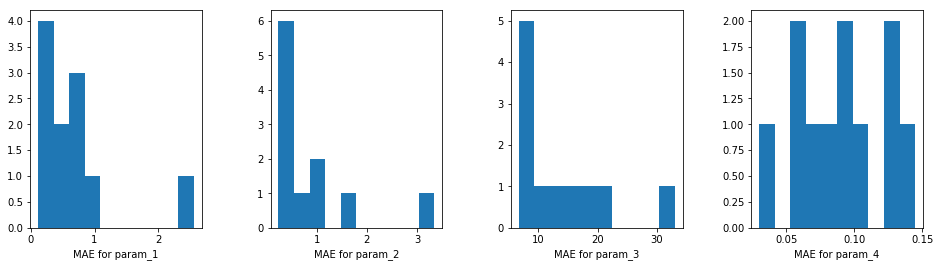

In [28]:
fig = plt.figure(figsize=(16, 4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
n_plots= 4
print("Mean Absolute errors for %d drugs" % df_errors.shape[0])
parameters_to_show = ["mae_param_"+str(i+1) for i in range(4)]
for i in range(n_plots):
    ax = fig.add_subplot(1, n_plots, i+1)
    ax.hist(df_errors[parameters_to_show[i]])
    ax.set_xlabel("MAE for param_"+str(i+1))

In [30]:
print("Merged data:", short_test.shape[0])
print("Merged and Fitted data with predicted R2>0.9:", short_test[short_test["r2_predicted"]>0.9].shape[0])

Merged data: 300
Merged and Fitted data with predicted R2>0.9: 22


**Observation:**
    14% of the data is predicted well (R2<0.9)

In [31]:
short_test["DRUG_ID"].nunique(), short_test[short_test["r2_predicted"]<0.9]["DRUG_ID"].nunique()

(11, 11)

In [32]:
less_09 = short_test[short_test["r2_predicted"]<=0.9]
above_09 = short_test[short_test["r2_predicted"]>0.9]

In [35]:
d1 = above_09.groupby("DRUG_ID")[["COSMIC_ID"]].count().reset_index()
d2 = less_09.groupby("DRUG_ID")[["COSMIC_ID"]].count().reset_index()
compare_df = pd.merge(left = d1, right = d2, how= "outer", on = "DRUG_ID").fillna(0).rename(columns = {"COSMIC_ID_x": "above_09", "COSMIC_ID_y": "less_09"})
compare_df["sum"] = compare_df["above_09"]+compare_df["less_09"]
compare_df["percent_success"] = compare_df["above_09"]*100/(compare_df["sum"])
compare_df = pd.merge(left = compare_df, right = drug_features, how= "left", on = "DRUG_ID")
compare_df.sort_values(by="percent_success", ascending=False)

,DRUG_ID,above_09,less_09,sum,percent_success,Drug Name,Synonyms,Target,Target Pathway
4,276,8.0,22,30.0,26.666667,CAY10603,-,"HDAC1, HDAC6",Chromatin histone acetylation
1,219,6.0,20,26.0,23.076923,AT-7519,AT7519,"CDK1, CDK2, CDK4, CDK6, CDK9",Cell cycle
5,346,3.0,15,18.0,16.666667,THZ-2-102-1,-,CDK7,Cell cycle
3,273,3.0,29,32.0,9.375000,CUDC-101,CUDC 101,"HDAC1-10, EGFR, ERBB2",Other
0,170,1.0,30,31.0,3.225806,Shikonin,Anchusin,not defined,Other
2,272,1.0,32,33.0,3.030303,AR-42,"HDAC-42, AR 42, AR42",HDAC1,Chromatin histone acetylation
6,173,0.0,16,16.0,0.000000,FH535,-,"PPARgamma, PPARdelta",WNT signaling
7,180,0.0,22,22.0,0.000000,Thapsigargin,Octanoic acid,SERCA,Other
8,200,0.0,27,27.0,0.000000,Dacinostat,"NVP-LAQ824, LAQ824",HDAC1,Chromatin histone acetylation
9,274,0.0,30,30.0,0.000000,Belinostat,"PXD101, PXD-101",HDAC1,Chromatin histone acetylation


Number of drugs with number of good predictions above 70%: 0


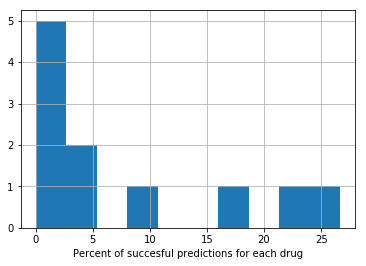

In [36]:
print("Number of drugs with number of good predictions above 70%:", sum(compare_df["percent_success"]>70))
compare_df["percent_success"].hist()
plt.xlabel("Percent of succesful predictions for each drug");

In [37]:
l1 = above_09.groupby("COSMIC_ID")[["DRUG_ID"]].count().reset_index()
l2 = less_09.groupby("COSMIC_ID")[["DRUG_ID"]].count().reset_index()

compare_line = pd.merge(left = l1, right = l2, how= "outer", on = "COSMIC_ID").fillna(0).rename(columns = {"DRUG_ID_x": "above_09", "DRUG_ID_y": "less_09"})
print(compare_line.shape)
compare_line["sum"] = compare_line["above_09"]+compare_line["less_09"]
compare_line["percent_success"] = compare_line["above_09"]*100/(compare_line["sum"])
compare_line[compare_line["sum"]>5].sort_values(by="percent_success", ascending=False)

(262, 3)


,COSMIC_ID,above_09,less_09,sum,percent_success


In [38]:
compare_line[compare_line["percent_success"]==0].shape[0]

240